In [1]:
import pandas as pd, numpy as np, requests, time, csv, datetime, re, os
pd.set_option("max_rows", 100)
import xml.etree.ElementTree
from matplotlib import pyplot as plt
%matplotlib inline

In [9]:
# function to keep lists of predictions, train numbers the same length
# useful for adding these lists to DataFrames

def addNaN(list2pass, list_length):
    
    list2pass = sorted(list2pass)
    list2pass = list2pass[:list_length]
    
    
    while len(list2pass) < list_length:
        list2pass += [np.NaN]
    return list2pass

def toReadableTime(ts):
    return datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S').split()[1]
def toReadableDateTime(ts):
    return datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')

def dayIncrement(readYear, readMonth, readDay):
    # 30-day months
    if readMonth in ["04","06","09","11"]:
        if readDay == "30":
            nextDate = readYear + "-" + str(int(readMonth) + 1).zfill(2) + "-01"
        elif int(readDay) > 30:
            print("INVALID DATE")
            nextDate = "INVALID DATE"
        else:
            nextDate = readYear + "-" + readMonth + "-" + str(int(readDay) + 1).zfill(2)
    # 31-day months
    elif readMonth in ["01","03","05","07","08","10"]:
        if readDay == "31":
            nextDate = readYear + "-" + str(int(readMonth) + 1).zfill(2) + "-01"
        elif int(readDay) > 31:
            print("INVALID DATE")
            nextDate = "INVALID DATE"
        else:
            nextDate = readYear + "-" + readMonth + "-" + str(int(readDay) + 1).zfill(2)
    # December
    elif readMonth == "12":
        if readDay == "31":
            nextDate = str(int(readYear) + 1) + "-" + "01-01"
        elif int(readDay) > 31:
            print("INVALID DATE")
            nextDate = "INVALID DATE"
        else:
            nextDate = readYear + "-" + readMonth + "-" + str(int(readDay) + 1).zfill(2)
    # February
    elif readMonth == "02":
        if int(readYear) % 4 != 0:
            if readDay == "28":
                nextDate = readYear + "-" + str(int(readMonth) + 1).zfill(2) + "-01"
            elif int(readDay) > 31:
                print("INVALID DATE")
                nextDate = "INVALID DATE"
            else:
                nextDate = readYear + "-" + readMonth + "-" + str(int(readDay) + 1).zfill(2)
        else:
            if readDay == "29":
                nextDate = readYear + "-" + str(int(readMonth) + 1).zfill(2) + "-01"
            elif int(readDay) > 31:
                print("INVALID DATE")
                nextDate = "INVALID DATE"
            else:
                nextDate = readYear + "-" + readMonth + "-" + str(int(readDay) + 1).zfill(2)
    else:
        pass
    return nextDate

def consist_to_four_digit(consist):
    if pd.isnull(consist) == False and len(str(consist))>0:
        if type(consist) == str:
            consist = int(consist)
            if consist >= 1 and consist <= 400:
                fourdigitconsist = consist + 1199
            elif consist >= 501 and consist <= 999:
                fourdigitconsist = consist + 1499
            else:
                fourdigitconsist = int(consist)

        else:
            consist = int(consist)
            if consist >= 1 and consist <= 400:
                fourdigitconsist = consist + 1199
            elif consist >= 501 and consist <= 999:
                fourdigitconsist = consist + 1499
            else:
                fourdigitconsist = int(consist)
    else:
        fourdigitconsist = np.NaN
    return fourdigitconsist

def loadSMC(day2read):
    # getfile = "http://nbsnap/atcslogs/SmcSls/%sSLS.smc" % str(datetime.datetime.today()).split()[0].replace("-","")[2:]
    # day2read should be in the format YYYY-MM-DD
    
    readYear = day2read.split("-")[0]
    readMonth= day2read.split("-")[1]
    readDay= day2read.split("-")[2]
    
    #getfile = "http://nbsnap/atcslogs/SmcSls/{}SLS.smc".format((readYear[2:]+readMonth+readDay))
    getfile = "{}SLS.smc".format((readYear[2:]+readMonth+readDay))
    
    readMsg = "Running for {}-{}-{}".format(readYear, readMonth, readDay)
    print(readMsg)
    s = requests.get(getfile)
    print(s)
    
    smc = s.text
    smcrecords = smc.replace("\n","").split("\r")
    
    # remove records we don't want, so future operations are faster
    poplist = []
    couples = []

    print(len(smcrecords), "initial records")

    for i in range(len(smcrecords)):
        rec = smcrecords[i].replace("{", "").replace("}","").split()

        if "Arrived" in rec and "Destination" in rec and "Platform" in rec:
            pass
        elif "Vehicle" in rec and "IDs" in rec:
            couples.append(smcrecords[i])
            poplist.append(i)
        else:    
            poplist.append(i)

    for item in reversed(poplist):
        smcrecords.pop(item)

    print(len(smcrecords), "arrival records")
    
    smcrecords = smc.replace("\n","").split("\r")
    
    coupleDict = {}

    for couple in couples:

        info = couple.replace("{", "").replace("}","").split()

        veh1 = consist_to_four_digit(info[6])
        veh2 = consist_to_four_digit(info[7])

        coupleDict[veh1] = veh2
        
    # remove records we don't want, so future operations are faster
    poplist = []
    couples = []

    for i in range(len(smcrecords)):
        rec = smcrecords[i].replace("{", "").replace("}","").split()

        if "Arrived" in rec and "Destination" in rec and "Platform" in rec:
            pass
        elif "Vehicle" in rec and "IDs" in rec:
            couples.append(smcrecords[i])
            poplist.append(i)
        else:    
            poplist.append(i)

    for item in reversed(poplist):
        smcrecords.pop(item)
        
    dfs = []

    for record in smcrecords:
        rec = [x.replace("{","").replace("}","") for x in record.split(" ",2)]
        dfs.append(pd.DataFrame([rec], columns=["TIME", "SRS_ID", "MSG"]))

    smcdf = pd.concat(dfs, ignore_index=True)

    smcdf["CONSIST"] = [re.sub("\D", "", x.lower().split()[x.lower().split().index('consist')+1]) if "consist" in x.lower().split() else '' for x in smcdf['MSG']]

    smcdf["FOUR_DIGIT_CONSIST"] = [consist_to_four_digit(x) for x in smcdf['CONSIST']]
    smcdf["PLATFORM"] = [x.split()[x.split().index("Platform")+1] for x in smcdf["MSG"]]
    
    smcdf["H"] = [int(x.split(":")[0]) for x in smcdf["TIME"]]
    dayChangeIdx = smcdf[smcdf["H"].diff() < 0].index[0]
    smcdf.drop("H", axis=1, inplace=True)
    
    smcdf["DAY"] = np.NaN
    smcdf.loc[:(dayChangeIdx-1), "DAY"] = day2read
    smcdf.loc[dayChangeIdx:, "DAY"] = dayIncrement(readYear=readYear, readMonth=readMonth, readDay=readDay)
    
    smcdf["DATETIME"] = smcdf["DAY"] + " " + smcdf["TIME"]
    
    
    #smcdf["DATETIME"] = [pd.to_datetime("2019-01-16 " +x) for x in smcdf["TIME"]]
    smcdf["UNIX"] = [(time.mktime(time.strptime(str(x).split(".")[0], "%Y-%m-%d %H:%M:%S"))) for x in smcdf["DATETIME"]]
    
    return smcdf, coupleDict

def generateUniqueId(uid_no):
    return str(datetime.datetime.today()).split()[0] + "--" + str(uid_no)

## Load in NextBus data from 1-16-19

In [5]:
filepath = "NB-VNR-2019-01-16.csv"

In [6]:
data = pd.read_csv(filepath)
sample = data.query("Seconds < 600")

## Load in ATCS data from 1-16-19

In [11]:
! ls

190116SLS.smc             FullDayAnalysis.ipynb     NextBusListener-VNR.ipynb
ATCSComparison.ipynb      NB-VNR-2019-01-16.csv


Load SMC data from file, not via Central Control website.

In [37]:
%%time

smcobject = open("190116SLS.smc", "r")
smclist = []


for x in smcobject:
    smclist.append(x)

smcrecords = [x.replace("\n", "").strip() for x in smclist]

del smclist

CPU times: user 464 ms, sys: 59.1 ms, total: 523 ms
Wall time: 553 ms


In [40]:
day2read = "2019-01-16"
readYear = day2read.split("-")[0]
readMonth= day2read.split("-")[1]
readDay= day2read.split("-")[2]


# remove records we don't want, so future operations are faster
poplist = []
couples = []

print(len(smcrecords), "initial records")

for i in range(len(smcrecords)):
    rec = smcrecords[i].replace("{", "").replace("}","").split()

    if "Arrived" in rec and "Destination" in rec and "Platform" in rec:
        pass
    elif "Vehicle" in rec and "IDs" in rec:
        couples.append(smcrecords[i])
        poplist.append(i)
    else:    
        poplist.append(i)

for item in reversed(poplist):
    smcrecords.pop(item)

print(len(smcrecords), "arrival records")

smcobject = open("190116SLS.smc", "r")
smclist = []


for x in smcobject:
    smclist.append(x)

smcrecords = [x.replace("\n", "").strip() for x in smclist]

del smclist

coupleDict = {}

for couple in couples:

    info = couple.replace("{", "").replace("}","").split()

    veh1 = consist_to_four_digit(info[6])
    veh2 = consist_to_four_digit(info[7])

    coupleDict[veh1] = veh2

# remove records we don't want, so future operations are faster
poplist = []
couples = []

for i in range(len(smcrecords)):
    rec = smcrecords[i].replace("{", "").replace("}","").split()

    if "Arrived" in rec and "Destination" in rec and "Platform" in rec:
        pass
    elif "Vehicle" in rec and "IDs" in rec:
        couples.append(smcrecords[i])
        poplist.append(i)
    else:    
        poplist.append(i)

for item in reversed(poplist):
    smcrecords.pop(item)

dfs = []

for record in smcrecords:
    rec = [x.replace("{","").replace("}","") for x in record.split(" ",2)]
    dfs.append(pd.DataFrame([rec], columns=["TIME", "SRS_ID", "MSG"]))

smcdf = pd.concat(dfs, ignore_index=True)

smcdf["CONSIST"] = [re.sub("\D", "", x.lower().split()[x.lower().split().index('consist')+1]) if "consist" in x.lower().split() else '' for x in smcdf['MSG']]

smcdf["FOUR_DIGIT_CONSIST"] = [consist_to_four_digit(x) for x in smcdf['CONSIST']]
smcdf["PLATFORM"] = [x.split()[x.split().index("Platform")+1] for x in smcdf["MSG"]]

smcdf["H"] = [int(x.split(":")[0]) for x in smcdf["TIME"]]
dayChangeIdx = smcdf[smcdf["H"].diff() < 0].index[0]
smcdf.drop("H", axis=1, inplace=True)

smcdf["DAY"] = np.NaN
smcdf.loc[:(dayChangeIdx-1), "DAY"] = day2read
smcdf.loc[dayChangeIdx:, "DAY"] = dayIncrement(readYear=readYear, readMonth=readMonth, readDay=readDay)

smcdf["DATETIME"] = smcdf["DAY"] + " " + smcdf["TIME"]


#smcdf["DATETIME"] = [pd.to_datetime("2019-01-16 " +x) for x in smcdf["TIME"]]
smcdf["UNIX"] = [(time.mktime(time.strptime(str(x).split(".")[0], "%Y-%m-%d %H:%M:%S"))) for x in smcdf["DATETIME"]]


8497 initial records
8497 arrival records


__reconfigured to work for reading in SMC logs from file__

In [43]:
smc = smcdf
coupleDict = {}

for couple in couples:

    info = couple.replace("{", "").replace("}","").split()

    veh1 = consist_to_four_digit(info[6])
    veh2 = consist_to_four_digit(info[7])

    coupleDict[veh1] = veh2

In [10]:
smc, coupleDict = loadSMC("2019-01-16")

Running for 2019-01-16


MissingSchema: Invalid URL '190116SLS.smc': No schema supplied. Perhaps you meant http://190116SLS.smc?

In [50]:
vnr = smc[smc["PLATFORM"] == "VNR"].reset_index(drop=True)

vnr = vnr[["DATETIME","TIME", "UNIX", "FOUR_DIGIT_CONSIST"]]
vnr["SECOND_CONSIST"] = [coupleDict[x] for x in vnr["FOUR_DIGIT_CONSIST"]]
len(vnr)

541

In [51]:
t_min = data['Timestamp'].min() - 360
t_max = data["Timestamp"].max() + 360

vnr_t = vnr[(vnr["UNIX"] > t_min) & (vnr["UNIX"] < t_max)]
print(len(vnr_t))

388


In [52]:
%%time

vehicles = list(data["Vehicle"].unique())

print(len(vehicles), "unique vehicles.")

arrivals = pd.DataFrame(columns=["Timestamp", "Line", "Vehicle", "Seconds", "Diff", "Cut-Off", "UID"])

uid_no = 1
for vehicle in vehicles:
    
    testtrain = data[data["Vehicle"] == vehicle]
    testtrain["Diff"] = testtrain["Timestamp"].diff()
    testtrain["Cut-Off"] = testtrain["Diff"] >= (45*60)
    o = 0
    #print(vehicle, "-", len(list(testtrain[testtrain["Cut-Off"]].index)))
    for i in list(testtrain[testtrain["Cut-Off"]].index) + [testtrain.index.max()]:
        #unique_train = generateUniqueId(uid_no)
        unique_train = "UID-"+str(uid_no)
        #print(unique_train)
        #print(testtrain.loc[o:i-1])

        try:
            #ii = testtrain["Seconds"].loc[o:i-1].idxmin()
            ii = testtrain["Seconds"].loc[o:i].idxmin()
            values = list(testtrain.loc[ii]) + [unique_train]
            #print(values)
            
            df2 = pd.DataFrame([values], columns=["Timestamp", "Line", "Vehicle", "Seconds", "Diff", "Cut-Off", "UID"])
            arrivals = arrivals.append(df2, ignore_index=True)
            
        except:
            pass
            #print(vehicle)
        uid_no += 1
        o = i
arrivals = arrivals.sort_values("Timestamp")[["Timestamp", "Line", "Vehicle", "Seconds", "UID"]].reset_index(drop=True)

print(arrivals["UID"].nunique(), "unique arrival IDs")

arrivals["Arrival Timestamp"] = arrivals["Timestamp"] + arrivals["Seconds"]
arrivals["Arrival Time"] = [toReadableTime(x) for x in arrivals["Arrival Timestamp"]]

141 unique vehicles.


/Users/mapsense-simon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/mapsense-simon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


487 unique arrival IDs
CPU times: user 40.9 s, sys: 348 ms, total: 41.2 s
Wall time: 43.7 s


In [55]:
# writing this to CSV so I don't have to load it all up next time.
arrivals.to_csv("NBarrivals190116.csv")

## Match NextBus Arrivals to ATCS Arrivals

In [53]:
arrivals.loc[indices][arrivals["UID"] == "UID-32"]

NameError: name 'indices' is not defined

In [52]:
arrivals

,Timestamp,Line,Vehicle,Seconds,UID,Arrival Timestamp,Arrival Time
0,1.547643e+09,M,1525.0,600.0,UID-41,1.547644e+09,05:05:12
1,1.547644e+09,KT,1505.0,13.0,UID-32,1.547644e+09,04:59:12
2,1.547644e+09,J,2042.0,1.0,UID-54,1.547644e+09,05:06:04
3,1.547644e+09,L,1512.0,1516.0,UID-27,1.547646e+09,05:35:06
4,1.547644e+09,L,1411.0,551.0,UID-1,1.547645e+09,05:20:47
5,1.547644e+09,M,1456.0,8.0,UID-14,1.547644e+09,05:13:46
6,1.547645e+09,J,1496.0,13.0,UID-7,1.547645e+09,05:19:09
7,1.547645e+09,KT,1436.0,6.0,UID-34,1.547645e+09,05:25:07
8,1.547645e+09,L,1430.0,5.0,UID-78,1.547645e+09,05:26:22
9,1.547645e+09,L,1545.0,489.0,UID-38,1.547646e+09,05:34:26


In [54]:
runDate = "2019-01-16"

resultsCols = ["Date", "ArrivalTimestamp","ArrivalTime","NextBus_Vehicle", "Line", "Matched"]
results = pd.DataFrame(columns=resultsCols)

tolerance = 60 # how close a train has to be predicting for it be considered to be an accurate arrival
query = "Seconds <= {}".format(str(tolerance))

indices = arrivals.query(query).index

nbArrivals = len(indices)
matchedTrains = 0

smcMatches = []

for i in indices:
    
    timeSearchBuffer = 180 # number of seconds before and after the NextBus Arrival to search for a match in the ATCS logs
    
    nb_arrival_timestamp = arrivals['Arrival Timestamp'][i]
    nb_arrival_time = arrivals["Arrival Time"][i]
    nb_vehicle = arrivals["Vehicle"][i]
    nb_uid = arrivals["UID"][i]
    nb_line = arrivals["Line"][i]
    date = toReadableDateTime(arrivals["Arrival Timestamp"][i]).split(" ")[0]
    
    upper_limit = nb_arrival_timestamp + timeSearchBuffer
    lower_limit = nb_arrival_timestamp - timeSearchBuffer

    smc_query = "UNIX >= {} & UNIX <= {}".format(str(lower_limit), str(upper_limit))
    
    timeMatches = vnr_t.query(smc_query)
    
    
    # First, use a time buffer to check for matching IDs within a certain time-span
    
    if nb_vehicle in list(timeMatches["FOUR_DIGIT_CONSIST"]):
        print(nb_vehicle, "MATCHED //", nb_uid, "(1)", nb_line)
        idx = (timeMatches[timeMatches["FOUR_DIGIT_CONSIST"] == nb_vehicle].index)[0]
        results = results.append(pd.DataFrame([[date, nb_arrival_timestamp, nb_arrival_time, nb_vehicle, nb_line, True]], columns=resultsCols), ignore_index=True)
        smcMatches.append(idx)
        matchedTrains += 1
    elif nb_vehicle in list(timeMatches["SECOND_CONSIST"]):
        print(nb_vehicle, "MATCHED //", nb_uid, "(2)", nb_line)
        idx = (timeMatches[timeMatches["SECOND_CONSIST"] == nb_vehicle].index)[0]
        results = results.append(pd.DataFrame([[date, nb_arrival_timestamp, nb_arrival_time, nb_vehicle, nb_line, True]], columns=resultsCols), ignore_index=True)
        smcMatches.append(idx)
        matchedTrains += 1
    
    # if there are no matching IDs within the time span, investigate non-matching IDs in that time-span
       
    else:
        otherVehicles = list(arrivals.loc[indices][(arrivals["Timestamp"] >= lower_limit) & (arrivals["Timestamp"] <= upper_limit)]["Vehicle"])
        otherVehicles.remove(nb_vehicle)
        inTimeRange_noIDMatch = timeMatches[(timeMatches["FOUR_DIGIT_CONSIST"].isin(otherVehicles) == False) & (timeMatches["SECOND_CONSIST"].isin(otherVehicles) == False)]
        
        if len(inTimeRange_noIDMatch) == 1:
            print(nb_vehicle, "MATCHED //", nb_uid, "(TIME-BASED)", nb_line)
            results = results.append(pd.DataFrame([[date, nb_arrival_timestamp, nb_arrival_time, nb_vehicle, nb_line, True]], columns=resultsCols), ignore_index=True)
        elif len(inTimeRange_noIDMatch) == 0:
            results = results.append(pd.DataFrame([[date, nb_arrival_timestamp, nb_arrival_time, nb_vehicle, nb_line, False]], columns=resultsCols), ignore_index=True)
            print(nb_vehicle, "** NO MATCH", nb_line, "@", toReadableTime(nb_arrival_timestamp), "--", "all other vehicles in time window matched to other NB records.")
        else:
            results = results.append(pd.DataFrame([[date, nb_arrival_timestamp, nb_arrival_time, nb_vehicle, nb_line, False]], columns=resultsCols), ignore_index=True)
            print(nb_vehicle, "** NO MATCH", nb_line, "@", toReadableTime(nb_arrival_timestamp), "--", len(inTimeRange_noIDMatch), "possible match(es)")
results.to_csv("results/MatchResults-" + runDate + ".csv", index_label=False)
        
print()
print(matchedTrains, "out of", nbArrivals, "Matched.")
print(round((matchedTrains/nbArrivals),2), "Match Rate")

1505 MATCHED // UID-32 (1) KT
2042 MATCHED // UID-54 (1) J
1456 MATCHED // UID-14 (1) M
1496 MATCHED // UID-7 (1) J
1436 MATCHED // UID-34 (1) KT
1430 MATCHED // UID-78 (1) L
2010 MATCHED // UID-83 (1) KT
1479 MATCHED // UID-18 (1) J
1487 MATCHED // UID-46 (1) N
1438 MATCHED // UID-31 (TIME-BASED) M
1512 MATCHED // UID-28 (1) L
1484 MATCHED // UID-92 (1) KT
1468 MATCHED // UID-113 (1) M
1449 MATCHED // UID-95 (1) L
1412 MATCHED // UID-51 (1) N
2041 MATCHED // UID-62 (1) J
1445 MATCHED // UID-100 (1) KT


/Users/mapsense-simon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2028 MATCHED // UID-103 (1) J
1507 MATCHED // UID-116 (2) M
1441 MATCHED // UID-120 (1) L
1403 MATCHED // UID-109 (1) N
1457 MATCHED // UID-125 (1) KT
1524 MATCHED // UID-146 (1) N
2042 MATCHED // UID-55 (1) J
1453 MATCHED // UID-185 (1) L
1469 MATCHED // UID-131 (1) M
1503 MATCHED // UID-157 (1) KT
2025 MATCHED // UID-177 (1) L
1481 MATCHED // UID-153 (1) N
1409 MATCHED // UID-167 (1) M
1428 ** NO MATCH J @ 06:35:32 -- all other vehicles in time window matched to other NB records.
1525 MATCHED // UID-42 (1) M
1496 MATCHED // UID-8 (1) J
2044 MATCHED // UID-189 (1) KT
2046 MATCHED // UID-196 (1) N
1411 MATCHED // UID-2 (1) L
1510 MATCHED // UID-203 (1) N
1404 MATCHED // UID-201 (1) KT
1515 MATCHED // UID-225 (1) N
2045 MATCHED // UID-211 (1) J
2029 MATCHED // UID-207 (1) M
1461 MATCHED // UID-217 (2) L
1528 MATCHED // UID-223 (1) KT
1519 MATCHED // UID-232 (1) N
1545 MATCHED // UID-39 (1) L
1479 MATCHED // UID-19 (1) J
1548 MATCHED // UID-241 (1) KT
1536 MATCHED // UID-249 (1) N
1439 M

1406 MATCHED // UID-382 (1) N
1526 MATCHED // UID-376 (1) L
1481 MATCHED // UID-156 (1) N
2010 MATCHED // UID-85 (1) KT
1536 MATCHED // UID-250 (1) L
2042 MATCHED // UID-60 (1) J
1507 MATCHED // UID-119 (2) M
1529 MATCHED // UID-324 (1) M
1540 MATCHED // UID-194 (1) L
2046 MATCHED // UID-200 (TIME-BASED) N
1400 MATCHED // UID-479 (1) KT
2011 MATCHED // UID-337 (1) N
1510 MATCHED // UID-206 (1) N
1439 MATCHED // UID-239 (1) L
1508 MATCHED // UID-311 (1) M
1515 MATCHED // UID-227 (1) N
2015 MATCHED // UID-418 (1) KT
1543 MATCHED // UID-392 (1) KT
1412 MATCHED // UID-53 (1) N
1428 ** NO MATCH J @ 15:51:38 -- all other vehicles in time window matched to other NB records.
1441 MATCHED // UID-123 (1) L
1432 MATCHED // UID-366 (1) J
1447 MATCHED // UID-176 (1) M
1483 MATCHED // UID-252 (1) S
1464 MATCHED // UID-477 (1) J
1541 MATCHED // UID-423 (1) L
1482 MATCHED // UID-90 (1) M
1542 MATCHED // UID-371 (1) N
1500 MATCHED // UID-279 (2) L
1519 MATCHED // UID-235 (1) N
1410 MATCHED // UID-256 (

FileNotFoundError: [Errno 2] No such file or directory: 'results/MatchResults-2019-01-16.csv'

## Match ATCS Arrivals to NextBus Arrivals

In [38]:
arrivals.columns

Index(['Timestamp', 'Line', 'Vehicle', 'Seconds', 'UID', 'Arrival Timestamp',
       'Arrival Time'],
      dtype='object')

In [66]:
vnr_t

,DATETIME,TIME,UNIX,FOUR_DIGIT_CONSIST,SECOND_CONSIST
0,2019-01-16 04:39:25,04:39:25,1.547642e+09,1534,1445
1,2019-01-16 04:59:29,04:59:29,1.547644e+09,1505,1502
2,2019-01-16 05:06:51,05:06:51,1.547644e+09,2042,0
3,2019-01-16 05:11:22,05:11:22,1.547644e+09,2042,0
4,2019-01-16 05:14:03,05:14:03,1.547644e+09,1456,1525
5,2019-01-16 05:19:27,05:19:27,1.547645e+09,1496,0
6,2019-01-16 05:25:24,05:25:24,1.547645e+09,1436,1416
7,2019-01-16 05:26:39,05:26:39,1.547645e+09,1430,1411
8,2019-01-16 05:28:02,05:28:02,1.547645e+09,2010,2047
9,2019-01-16 05:37:46,05:37:46,1.547646e+09,1479,0


In [86]:
atcsMatched = 0
atcsTotal = 0

for i in vnr_t.index:
    
    atcs_arrival_time = vnr_t.loc[i, "UNIX"]
    atcs_car1 = vnr_t.loc[i, "FOUR_DIGIT_CONSIST"]
    atcs_car2 = vnr_t.loc[i, "SECOND_CONSIST"]
    
    timeSearchBuffer = 180 # number of seconds before and after the ATCS Arrival to search for a match in the NextBus data
    
    upper_limit = atcs_arrival_time + timeSearchBuffer
    lower_limit = atcs_arrival_time - timeSearchBuffer
    
    timeMatches = arrivals[(arrivals["Timestamp"] > lower_limit) & (arrivals["Timestamp"] < upper_limit)]
    timeMatchesVehiclesNB = list(timeMatches["Vehicle"].unique())
    timeMatchesVehiclesATCS = list(vnr_t[(vnr_t["UNIX"] > lower_limit) & (vnr_t["UNIX"] < upper_limit)]["FOUR_DIGIT_CONSIST"]) + list(vnr_t[(vnr_t["UNIX"] > lower_limit) & (vnr_t["UNIX"] < upper_limit)]["SECOND_CONSIST"])
    
    try:
        timeMatchesVehiclesATCS.remove(atcs_car1)
    except:
        pass
    try:
        timeMatchesVehiclesATCS.remove(atcs_car2)
    except:
        pass
    
    if len(timeMatchesVehiclesATCS) > 0:
        for veh in timeMatchesVehiclesATCS:
            try:
                timeMatchesVehiclesNB.remove(veh)
            except:
                pass
    else:
        pass
    
    if atcs_car1 in timeMatchesVehiclesNB or atcs_car2 in timeMatchesVehiclesNB:
        print(atcs_car1, "Matched!")
        atcsMatched += 1
    elif len(timeMatchesVehiclesNB) == 1:
        print(atcs_car1, "Matched!")
        atcsMatched += 1
    elif len(timeMatchesVehiclesNB) == 0:
        print(atcs_car1, "** No NextBus-predicted trains in arrival window")
    elif len(timeMatchesVehiclesNB) == 2:
        print(timeMatchesVehiclesNB, [coupleDict[x] for x in timeMatchesVehiclesNB])
        if timeMatchesVehiclesNB[0] in coupleDict or timeMatchesVehiclesNB[1] in coupleDict:
            print("hey")
            if coupleDict[timeMatchesVehiclesNB[0]] == timeMatchesVehiclesNB[1] or coupleDict[timeMatchesVehiclesNB[1]] == timeMatchesVehiclesNB[0]:
                print(atcs_car1, "Matched!")
                atcsMatched += 1
            else:
                print(atcs_car1, "Must be something else.")
    else:
        print(atcs_car1, "** unknown")
        
    atcsTotal += 1
    
print(round(atcsMatched/atcsTotal,2), "Match Rate")

1534 ** No NextBus-predicted trains in arrival window
1505 Matched!
2042 Matched!
[1512.0, 1411.0] [1545, 1430]
hey
2042 Must be something else.
1456 Matched!
1496 Matched!
1436 Matched!
1430 Matched!
2010 Matched!
1479 Matched!
1487 Matched!
1512 Matched!
1484 Matched!
1468 Matched!
1449 Matched!
1412 Matched!
2041 Matched!
1445 Matched!
2028 Matched!
1490 Matched!
1441 Matched!
1403 Matched!
1457 Matched!
1524 Matched!
2042 Matched!
1453 Matched!
1469 Matched!
1503 Matched!
2025 Matched!
1481 Matched!
1409 Matched!
1525 Matched!
1496 Matched!
2044 Matched!
2046 Matched!
1411 Matched!
1510 Matched!
1404 Matched!
1515 Matched!
2045 Matched!
2029 Matched!
1540 Matched!
1528 Matched!
1519 Matched!
1545 Matched!
1479 Matched!
1548 Matched!
1536 Matched!
1439 Matched!
2022 Matched!
2041 Matched!
1544 Matched!
1477 Matched!
1410 Matched!
1482 Matched!
1420 ** No NextBus-predicted trains in arrival window
1531 Matched!
1500 Matched!
2032 Matched!
1408 Matched!
1452 Matched!
2028 Matched!
147

In [71]:
timeMatchesVehiclesNB

[]

In [77]:
timeMatchesVehiclesATCS

[1513, 1515]

In [69]:
["cat", "fish"].remove("dog")

ValueError: list.remove(x): x not in list

In [45]:
atcsMatched/atcsTotal

0.8994845360824743

## Results

In [159]:
results[results["Matched"]==False]

,Date,ArrivalTimestamp,ArrivalTime,NextBus_Vehicle,Line,Matched
9,2019-01-16,1.547646e+09,05:44:04,1438.0,M,False
30,2019-01-16,1.547649e+09,06:35:32,1428.0,J,False
50,2019-01-16,1.547653e+09,07:30:53,1532.0,M,False
55,2019-01-16,1.547653e+09,07:35:59,1420.0,L,False
111,2019-01-16,1.547658e+09,09:06:47,1488.0,N,False
115,2019-01-16,1.547659e+09,09:15:26,1532.0,M,False
130,2019-01-16,1.547660e+09,09:35:27,1428.0,J,False
137,2019-01-16,1.547661e+09,09:44:55,1507.0,M,False
139,2019-01-16,1.547661e+09,09:48:58,1529.0,M,False
143,2019-01-16,1.547661e+09,09:55:11,2026.0,KT,False


In [135]:
pd.crosstab(results["Line"], results["Matched"],normalize="index", margins=True)

Matched,False,True
Line,,
J,0.076923,0.923077
KT,0.013333,0.986667
L,0.026316,0.973684
M,0.118644,0.881356
N,0.067416,0.932584
S,0.000000,1.000000
All,0.056300,0.943700


In [136]:
pd.crosstab(results["Line"], results["Matched"], margins=True)

Matched,False,True,All
Line,,,
J,5,60,65
KT,1,74,75
L,2,74,76
M,7,52,59
N,6,83,89
S,0,9,9
All,21,352,373


In [169]:
pd.crosstab(results["Date"], results["Matched"])

Matched,False,True
Date,,
2019-01-16,21,352


## Visualize

In [176]:
timePeriods = ["7:00:00", "10:00:00", "16:00:00", "19:00:00"]
[7,10,16,19]

[7, 10, 16, 19]

In [182]:
[int(toReadableTime(x).split(":")[0]) for x in lineSample["Timestamp"][:5]]

[4, 4, 4, 4, 4]

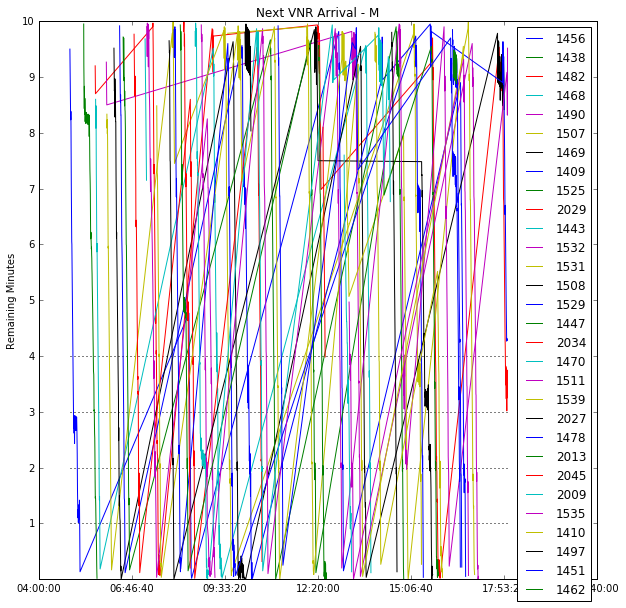

In [174]:
line = "M"

lineSample = sample[sample["Line"] == line]
timeSample = 


plt.clf()

plt.figure(figsize=(10,10))

for vehicle in list(lineSample['Vehicle'].unique()):
    
    #thisVehicle = 
    
    plt.plot(lineSample[lineSample['Vehicle'] == vehicle]["Timestamp"], lineSample[lineSample['Vehicle'] == vehicle]["Seconds"], "-", label=vehicle)
    #plt.plot(sample[sample['Vehicle'] == vehicle]["Timestamp"], sample[sample['Vehicle'] == vehicle]["Seconds"], "o")
    
plt.hlines(y=60,xmin=lineSample["Timestamp"].min(), xmax=lineSample["Timestamp"].max(),linestyles=":")
plt.hlines(y=120,xmin=lineSample["Timestamp"].min(), xmax=lineSample["Timestamp"].max(),linestyles=":")  
plt.hlines(y=180,xmin=lineSample["Timestamp"].min(), xmax=lineSample["Timestamp"].max(),linestyles=":")
plt.hlines(y=240,xmin=lineSample["Timestamp"].min(), xmax=lineSample["Timestamp"].max(),linestyles=":")  

plt.yticks([60,120,180,240,300,360,420,480,540,600], [1,2,3,4,5,6,7,8,9,10])
plt.ylabel("Remaining Minutes")

locs, labels = plt.xticks()
plt.xticks(locs, [toReadableTime(x) for x in list(locs)])

plt.legend()
title = "Next VNR Arrival - {}".format(line)
plt.title(title)


## MATCHER

This portion of the notebook contains testing of the Matcher. Matching will be structured as follows:

1. For a given arrival in Dataset A (ATCS or NB), a time window of arbitrary size will be established, and Dataset B will be subset to only contain arrivals within that time window.

  * If the Vehicle ID in Dataset A is found in the arrival records in the subset of Dataset B within the time window, the arrival from Dataset A is considered to be matched.
  * Existing Vehicle ID matches should be removed from the subset of Dataset B, so that arrivals in Dataset B that already have corresponding arrivals in Dataset A are not eligible for matching. If there is only one remaining record within the time window in Dataset B after existing matches are removed, the arrival from Dataset A is considered to be matched.
  
2. H

In [11]:
arrivals.loc[2, "Timestamp"]

1547643963.6513345

In [21]:
arrivals.loc[2]["Timestamp"]

1547643963.6513345

In [55]:
vnr_t.head()

,DATETIME,TIME,UNIX,FOUR_DIGIT_CONSIST,SECOND_CONSIST
0,2019-01-16 04:39:25,04:39:25,1.547642e+09,1534,1445
1,2019-01-16 04:59:29,04:59:29,1.547644e+09,1505,1502
2,2019-01-16 05:06:51,05:06:51,1.547644e+09,2042,0
3,2019-01-16 05:11:22,05:11:22,1.547644e+09,2042,0
4,2019-01-16 05:14:03,05:14:03,1.547644e+09,1456,1525


In [63]:
1445 in (list((1444, 1445)))

True

In [274]:
arrivals.columns

Index(['Timestamp', 'Line', 'Vehicle', 'Seconds', 'UID', 'Arrival Timestamp',
       'Arrival Time'],
      dtype='object')

In [311]:
arrivals[arrivals["Vehicle"]==2042].index

Int64Index([2, 34, 89, 147, 214, 252, 364, 433], dtype='int64')

In [71]:
def matcher(arrivalRowIdx, arrivalDF, searchDF, timeRadius, arrivalTimeCol, searchTimeCol):
    
    # generate time window
    arrivalTime = arrivalDF.loc[arrivalRowIdx, arrivalTimeCol]
    arrivalVehID = arrivalDF.loc[arrivalRowIdx, "Vehicle"]
    arrivalLine = arrivalDF.loc[arrivalRowIdx, "Line"]
    t_max = arrivalTime + timeRadius
    t_min = arrivalTime - timeRadius
    
    # generate DFs of only arrivals within the time window
    searchDFarrivals = searchDF[(searchDF[searchTimeCol] < t_max) & (searchDF[searchTimeCol] > t_min)]
    arrivalDFarrivals = arrivalDF[(arrivalDF[arrivalTimeCol] < t_max) & (arrivalDF[arrivalTimeCol] > t_min)]
    
    #print(len(searchDFarrivals), len(arrivalDFarrivals))
    
    if len(searchDFarrivals) > 0:
        dfs = []

        for i in searchDFarrivals.index:
            car1 = searchDFarrivals.loc[i, "FOUR_DIGIT_CONSIST"]
            unix = searchDFarrivals.loc[i, "UNIX"]

            #print(car1, car2)

            tempDF = test[(test["CONSIST"].isin([car1])) & (test["UNIX"] <= unix) & (test["UNIX"] >= (unix - (60*60)))].sort_values("UNIX")

            if len(tempDF) == 0:
                line = "X"
            else:
                line = tempDF.loc[tempDF["UNIX"].idxmax(), "LINE"]
            dfs.append(pd.DataFrame([[car1, line]], columns=["FOUR_DIGIT_CONSIST", "LINE"]))

        try:
            lineAssignments = pd.concat(dfs, ignore_index=True)
        except ValueError:
            print(len(searchDFarrivals))
        lineAssignments

        searchDFarrivals = searchDFarrivals.merge(lineAssignments, on="FOUR_DIGIT_CONSIST")

        # OK, now that the arrivals dataset (NB) is loaded and subset, and the search dataset (ATCS) is both subset and has lines assigned
        # we can proceed

        if arrivalVehID in list(searchDFarrivals["FOUR_DIGIT_CONSIST"]) or arrivalVehID in list(searchDFarrivals["SECOND_CONSIST"]):
            #print(arrivalVehID, "MATCHED BY VEHICLE ID")
            pass
        else:
            print()
            print(arrivalVehID, "**NO MATCH**")
            otherMatches = []
            for veh in arrivalDFarrivals["Vehicle"].unique():

                if veh in list(searchDFarrivals["FOUR_DIGIT_CONSIST"]):
                    otherMatches.append(veh)
                elif veh in list(searchDFarrivals["SECOND_CONSIST"]):
                    otherMatches.append(veh)
                else:
                    pass
            
            searchArrivals = searchDFarrivals[searchDFarrivals["FOUR_DIGIT_CONSIST"].isin(otherMatches) == False]
            
            if len(searchArrivals) == 0:
                print(arrivalVehID, "IS A GHOST TRAIN (via matching & removal)")
            elif len(searchArrivals) == 1:
                if arrivalLine == searchArrivals.iloc[0]["LINE"]:
                    print("MATCHED via removal & line.")
                elif searchArrivals.iloc[0]["LINE"] == "X":
                    print("Only eligible match is an out of service train")
                else:
                    
                    print("OPTION C - LINE", arrivalLine)
                    print(searchArrivals[["DATETIME", "FOUR_DIGIT_CONSIST", "SECOND_CONSIST", "LINE"]])
            elif len(searchArrivals) > 1:
                try:
                    obs = dict(sdf['LINE'].value_counts())[arrivalLine]
                except KeyError:
                    try:
                        if dict(sdf['LINE'].value_counts())["X"] == 1:
                            obs = 0
                            print("MATCHED TO A NON-COMMUNICATING TRAIN")
                        elif dict(sdf['LINE'].value_counts())["X"] > 1:
                            print("too many NCT/out of service trains")
                            obs = 0
                        else:
                            print("no records of that line present")
                            obs = 0
                    except KeyError:
                        obs = 0
                        print("no records of that line present")
                if obs == 1:
                    print("MATCHED via removal & line (only one match with predicted line.)")
                elif obs > 1:
                    print("More than 1 unmatched arrival of that line in the time window.")
                else:
                    print("OPTION A")
                    pass
            else:
                print("OPTION B")
                pass
    else:
        print(arrivalVehID, "IS A GHOST TRAIN//////////////////////////////////")
        
    return searchDFarrivals, arrivalDFarrivals

In [362]:
dict(sdf['LINE'].value_counts())["N"]

3

In [ ]:
searchArri

In [347]:
adf.iloc[1]["Line"]

'KT'

In [72]:
%%time

for x in arrivals[arrivals["Seconds"] <= 60].index:
    sdf, adf = matcher(arrivalRowIdx=x, arrivalDF=arrivals, searchDF=vnr_t, arrivalTimeCol="Arrival Timestamp", searchTimeCol="UNIX", timeRadius=180)


1438 **NO MATCH**
1438 IS A GHOST TRAIN (via matching & removal)

1428 **NO MATCH**
1428 IS A GHOST TRAIN (via matching & removal)

1532 **NO MATCH**
1532 IS A GHOST TRAIN (via matching & removal)

1420 **NO MATCH**
MATCHED via removal & line.

1488 **NO MATCH**
MATCHED via removal & line (only one match with predicted line.)

1532 **NO MATCH**
OPTION C - LINE M
              DATETIME  FOUR_DIGIT_CONSIST  SECOND_CONSIST LINE
0  2019-01-16 09:12:44                1514            1510    N

1428 **NO MATCH**
MATCHED via removal & line.

1507 **NO MATCH**
OPTION C - LINE M
              DATETIME  FOUR_DIGIT_CONSIST  SECOND_CONSIST LINE
0  2019-01-16 09:42:22                2014            2022    N

1529 **NO MATCH**
MATCHED via removal & line (only one match with predicted line.)

2026 **NO MATCH**
no records of that line present
OPTION A

1469 **NO MATCH**
OPTION C - LINE M
              DATETIME  FOUR_DIGIT_CONSIST  SECOND_CONSIST LINE
0  2019-01-16 09:54:59                2051       

In [77]:
matchCodes = {
    1 : "MATCHED ON VEHICLE ID",
    2 : "GHOST TRAIN; NO UN-MATCHED ARRIVALS",
    3 : "ONE REMAINING MATCH; SAME LINE",
    4 : "MATCHED TO OUT-OF-SERVICE TRAIN",
    5 : "ONE REMAINING MATCH; DIFFERENT LINES",
    6 : "UNMATCHED-UNKNOWN; MULTIPLE OUT-OF-SERVICE TRAINS",
    7 : "MATCHED; ONE UN-MATCHED RECORD HAS SAME LINE",
    8 : "UNMATCHED-UNKNOWN; MORE THAN 1 UNMATCHED ARRIVAL OF THAT LINE IN TIME-WINDOW",
    9 : "GHOST TRAIN; NO ATCS RECORDS IN TIME-WINDOW",
    10 : "UNMATCHED-UNKNOWN; MULTIPLE RECORDS OF OTHER LINES"
}

In [174]:
matchDescriptions = {
    "MATCHED ON VEHICLE ID" : "The vehicle ID is present in both the NextBus and ATCS datasets within the given time window.",
    "GHOST TRAIN; NO UN-MATCHED ARRIVALS" : "There are no un-matched arrivals in the ATCS dataset within the given time window",
    "ONE REMAINING MATCH; SAME LINE" : "There is one remaining un-matched arrival in the ATCS dataset within the given time window, and it is the same line as the NextBus arrival.",
    "MATCHED TO OUT-OF-SERVICE TRAIN" : "There is one remaining un-matched arrival in the ATCS dataset within the given time window, and it shown as an out-of-service train.",
    "ONE REMAINING MATCH; DIFFERENT LINES" : "There is one remaining un-matched arrival in the ATCS dataset within the given time window, and it is a different line than the NextBus arrival.",
    "UNMATCHED-UNKNOWN; MULTIPLE OUT-OF-SERVICE TRAINS" : "There are multiple remaining un-matched arrivals in the ATCS dataset within the given time window, and they are shown as out-of-service trains",
    "MATCHED; ONE UN-MATCHED RECORD HAS SAME LINE" : "There is one remaining un-matched arrival in the ATCS dataset within the given time window, and it is the same line as the NextBus arrival.",
    "UNMATCHED-UNKNOWN; MORE THAN 1 UNMATCHED ARRIVAL OF THAT LINE IN TIME-WINDOW" : "There are multiple remaining un-matched arrivals in the ATCS dataset within the given time window, and more than one is the same line as the NextBus arrival",
    "GHOST TRAIN; NO ATCS RECORDS IN TIME-WINDOW" : "There are no ATCS arrivals within the given time window.",
    "UNMATCHED-UNKNOWN; MULTIPLE RECORDS OF OTHER LINES" : "There are multiple remaining un-matched arrivals in the ATCS dataset within the given time window, and they are different lines than the NextBus arrival."
}

In [82]:
arrivalMatchingCols = ["NextBus Vehicle ID", "NextBus Arrival Time", "Match Code", "Match Code Description"]
arrivalMatching = pd.DataFrame(columns=arrivalMatchingCols)


numArrivals = len(arrivals[arrivals["Seconds"] <= 60].index)
matches = 0
confirmedGhosts = 0
matchedViaRemovalLine = 0

timeRadius = 180

for i in arrivals[arrivals["Seconds"] <= 60].index:
    # generate time window
    arrivalTime = arrivals.loc[i, "Timestamp"]
    arrivalVehID = arrivals.loc[i, "Vehicle"]
    arrivalLine = arrivals.loc[i, "Line"]
    t_max = arrivalTime + timeRadius
    t_min = arrivalTime - timeRadius
    
    # generate DFs of only arrivals within the time window
    searchDFarrivals = vnr_t[(vnr_t["UNIX"] < t_max) & (vnr_t["UNIX"] > t_min)]
    arrivalDFarrivals = arrivals[(arrivals["Timestamp"] < t_max) & (arrivals["Timestamp"] > t_min)]
    
    # ASSIGN LINE INFORMATION TO ATCS LOGS
    if len(searchDFarrivals) > 0:
        
        dfs = []

        for i in searchDFarrivals.index:
            car1 = searchDFarrivals.loc[i, "FOUR_DIGIT_CONSIST"]
            unix = searchDFarrivals.loc[i, "UNIX"]

            #print(car1, car2)

            tempDF = test[(test["CONSIST"].isin([car1])) & (test["UNIX"] <= unix) & (test["UNIX"] >= (unix - (60*60)))].sort_values("UNIX")

            if len(tempDF) == 0:
                line = "X"
            else:
                line = tempDF.loc[tempDF["UNIX"].idxmax(), "LINE"]
            dfs.append(pd.DataFrame([[car1, line]], columns=["FOUR_DIGIT_CONSIST", "LINE"]))

        try:
            lineAssignments = pd.concat(dfs, ignore_index=True)
        except ValueError:
            print(len(searchDFarrivals))

        searchDFarrivals = searchDFarrivals.merge(lineAssignments, on="FOUR_DIGIT_CONSIST")

        # OK, now that the arrivals dataset (NB) is loaded and subset, and the search dataset (ATCS) is both subset and has lines assigned
        # we can proceed
        
        
        
        if arrivalVehID in list(searchDFarrivals["FOUR_DIGIT_CONSIST"]) or arrivalVehID in list(searchDFarrivals["SECOND_CONSIST"]):
            
            # OPTION 1 -- MATCHED ON VEHICLE ID 
            # the vehicle ID is present in both datasets, thereby allowing us to make the match.
            # This NextBus arrival is therefore considered to be MATCHED.
            matchCodeID = 1
            matches += 1
        
        # If the vehicle ID is not found in the search dataset, we can take several actions.    
        else:
            
            # create an array of vehicle IDs that are present in both the substs of the arrivals dataset and the search dataset.
            # these records can be considered to be MATCHED, thereby removing them from our consideration
            otherMatches = []
            for veh in arrivalDFarrivals["Vehicle"].unique():

                if veh in list(searchDFarrivals["FOUR_DIGIT_CONSIST"]):
                    otherMatches.append(veh)
                elif veh in list(searchDFarrivals["SECOND_CONSIST"]):
                    otherMatches.append(veh)
                else:
                    pass
            
            # the resultant DF is all of the arrivals within the subset search dataset for which there are no matching vehicle
            # ID matches in the subset arrivals dataset
            
            searchArrivals = searchDFarrivals[searchDFarrivals["FOUR_DIGIT_CONSIST"].isin(otherMatches) == False]
            
            
            if len(searchArrivals) == 0:
                
                # OPTION 2 -- GHOST TRAIN; NO UN-MATCHED ARRIVALS
                # there are no un-matched arrivals in the subset search dataset
                # This NextBus arrival is therefore considered to be a GHOST TRAIN.
                matchCodeID = 2
                confirmedGhosts += 1
                print(arrivalVehID, "GHOST TRAIN -- no remaining, un-matched arrival in time window.")
            
            # if there is only one train in the remaining, un-matched subset of the search dataset, a number of outcomes can occur 
            elif len(searchArrivals) == 1:
                
                
                if arrivalLine == searchArrivals.iloc[0]["LINE"]:
                    
                    # OPTION 3 -- ONE REMAINING MATCH; SAME LINES
                    # the remaining, un-matched train in the subset search dataset is of the same line as the NextBus
                    # arrival being investigated, thereby allowing us to assert that the NextBus arrival matches this lone remaining
                    # un-matched ATCS arrival This NextBus arrival is therefore considered to be MATCHED.
                    
                    print(arrivalVehID, "MATCHED -- Matched via removal & line.")
                    matchCodeID = 3
                    matches += 1
                    matchedViaRemovalLine += 1
                
                
                
                elif searchArrivals.iloc[0]["LINE"] == "X":
                    
                    # OPTION 4 -- MATCHED TO OUT-OF-SERVICE TRAIN
                    # the remaining, un-matched train in the subset search dataset is of line "X", which indicates 
                    # an out of service train. Because this is the only matching train within the time window and it does not contain 
                    # any information that would conflict with the information about the NextBus arrival, we are able to assert that 
                    # the NextBus arrival matches this train that the train control system considers to be out-of-service.
                    
                    matchCodeID = 4
                    print(arrivalVehID, "MATCHED -- Only eligible match is an out of service train")
                
                
                else:
                    
                    # OPTION 5 -- ONE REMAINING MATCH; DIFFERENT LINES 
                    # the remaining, un-matched train in the subset search dataset is of a different line than the line of 
                    # the NextBus arrival being investigated.
                    
                    matchCodeID = 5
                    print(arrivalVehID, "One remaining match; mismatched lines:", arrivalLine, "vs.", searchArrivals.iloc[0]["LINE"])
    
            
            # if there is more than one remaining, un-matched arrival record in the subset search dataset, there are a number of
            # steps we can take to try to match those search dataset records with the NextBus record we're investigating
            
            elif len(searchArrivals) > 1:
                try:
                    # count the number of times the line of the NextBus arrival appears in the un-matched subset search DataFrame
                    obs = dict(sdf['LINE'].value_counts())[arrivalLine]
                    
                except KeyError:
                    # if the line of the NextBus arrival being investigated is not present in the subset search arrival records
                    # we first try to determine if there is a train considered to be out-of-service present
                    try:
                        if dict(sdf['LINE'].value_counts())["X"] == 1:
                            
                            # OPTION 4 -- MATCHED TO AN OUT-OF-SERVICE TRAIN
                            # if there are no arrival records from the un-matched, subset search dataset that match the line of the 
                            # NextBus arrival being investigated, but there is one out-of-service train in that subset, we can match
                            # that out-of-service train to the NextBus arrival. This NextBus arrival is therefore considered to be MATCHED.
                            
                            matchCodeID = 4
                            obs = 0
                            print(arrivalVehID, "MATCHED -- MATCHED TO A OUT-OF-SERVICE TRAIN")
                            
                        elif dict(sdf['LINE'].value_counts())["X"] > 1:
                            
                            # OPTION 6 -- UNMATCHED-UNKNOWN; MULTIPLE OUT-OF-SERVICE TRAINS
                            # if there are no arrival records from the un-matched, subset search dataset that match the line of the 
                            # NextBus arrival being investigated, but there is more than one out-of-service trains in that subset, we are
                            # unable to make a match across datasets. This NextBus arrival is therefore considered to be UNMATCHED-UNKNOWN.
                            
                            matchCodeID = 6
                            obs = 0
                            print(arrivalVehID, "UNMATCHED-UNKNOWN -- multiple out-of-service trains")
                            
                        else:
                            
                            # this scenario is impossible; if there are 0 records with line "X", the above IF statement will throw
                            # a KeyError
                            pass
                        
                    except KeyError:
                        obs = 0
                        
                        # OPTION 10 -- UNMATCHED-UNKNOWN; MULTIPLE RECORDS OF OTHER LINES
                        # of the remaining, un-matched records, there are multiple records belonging to other lines
                        # than the line indidicated in the NextBus data
                        
                        matchCodeID = 10
                        print(arrivalVehID, "UNMATCHED-UNKNOWN - No records of NextBus line or out-of-service trains. Multiple records of other lines.")
                
                if obs == 1:
                    
                    # OPTION 7 -- MATCHED; ONE UN-MATCHED RECORD HAS SAME LINE
                    # of the remaining, un-matched records from the subset search dataset, only one belongs to the same
                    # line as the NextBus arrival being investigated, which allows us to match the NextBus arrival to that search 
                    # record. This NextBus arrival is therefore considered to be MATCHED.
                    
                    matchCodeID = 7
                    print(arrivalVehID, "MATCHED --  via removal & line (only one match with predicted line.)")
                    matches += 1
                    
                elif obs > 1:
                    
                    # OPTION 8 -- UNMATCHED-UNKNOWN; MORE THAN 1 UNMATCHED ARRIVAL OF THAT LINE IN TIME-WINDOW
                    # if there is more than one un-matched arrival record from the subset search dataset that belongs to
                    # the same line as the NextBus arrival being investigated, we are unable to to match the NextBus arrival to an
                    # arrival in the subset search dataset. This NextBus arrival is therefore considered to be UNMATCHED-UNKNOWN.
                    
                    matchCodeID = 8
                    print(arrivalVehID, "UNMATCHED-UNKNOWN -- More than 1 unmatched arrival of that line in the time window.")
                
                else:
                    # OPTION 6 or OPTION 7 occurred and has been already noted.
                    pass
            else:
                # we can't have a DataFrame searchArrivals of negative length, so this scenario is impossible
                pass
    else:
        ## OPTION 9 -- GHOST TRAIN; NO RECORDS IN TIME-WINDOW 
        # no arrival records were present in the subset search dataset. 
        # This NextBus arrival is therefore considered to be a GHOST TRAIN.
        confirmedGhosts += 1
        matchCodeID = 9
        print(arrivalVehID, "GHOST TRAIN -- no arrivals in time window.")
        
    matchresults = [arrivalVehID, toReadableTime(arrivalTime), matchCodeID, matchCodes[matchCodeID]]
    arrivalMatching = arrivalMatching.append(pd.DataFrame([matchresults], columns=arrivalMatchingCols), ignore_index=True)  

1438 One remaining match; mismatched lines: M vs. N
1428 GHOST TRAIN -- no remaining, un-matched arrival in time window.
1532 GHOST TRAIN -- no remaining, un-matched arrival in time window.
1410 GHOST TRAIN -- no remaining, un-matched arrival in time window.
1420 MATCHED -- Matched via removal & line.
1488 UNMATCHED-UNKNOWN -- More than 1 unmatched arrival of that line in the time window.
1532 One remaining match; mismatched lines: M vs. N
1428 MATCHED -- Matched via removal & line.
1507 One remaining match; mismatched lines: M vs. N
1529 UNMATCHED-UNKNOWN - No records of NextBus line or out-of-service trains. Multiple records of other lines.
2026 UNMATCHED-UNKNOWN - No records of NextBus line or out-of-service trains. Multiple records of other lines.
1469 One remaining match; mismatched lines: M vs. N
1487 One remaining match; mismatched lines: N vs. M
1411 One remaining match; mismatched lines: L vs. M
2030 One remaining match; mismatched lines: N vs. L
1428 GHOST TRAIN -- no remaini

In [83]:
arrivalMatching

,NextBus Vehicle ID,NextBus Arrival Time,Match Code,Match Code Description
0,1505,04:58:59,1,MATCHED ON VEHICLE ID
1,2042,05:06:03,1,MATCHED ON VEHICLE ID
2,1456,05:13:38,1,MATCHED ON VEHICLE ID
3,1496,05:18:56,1,MATCHED ON VEHICLE ID
4,1436,05:25:01,1,MATCHED ON VEHICLE ID
5,1430,05:26:17,1,MATCHED ON VEHICLE ID
6,2010,05:27:32,1,MATCHED ON VEHICLE ID
7,1479,05:37:28,1,MATCHED ON VEHICLE ID
8,1487,05:40:46,1,MATCHED ON VEHICLE ID
9,1438,05:44:03,5,ONE REMAINING MATCH; DIFFERENT LINES


In [96]:
pd.DataFrame(round(arrivalMatching["Match Code Description"].value_counts()/len(arrivalMatching), 2))

,Match Code Description
MATCHED ON VEHICLE ID,0.94
ONE REMAINING MATCH; DIFFERENT LINES,0.03
GHOST TRAIN; NO UN-MATCHED ARRIVALS,0.01
UNMATCHED-UNKNOWN; MULTIPLE RECORDS OF OTHER LINES,0.01
ONE REMAINING MATCH; SAME LINE,0.01
MATCHED TO OUT-OF-SERVICE TRAIN,0.00
UNMATCHED-UNKNOWN; MORE THAN 1 UNMATCHED ARRIVAL OF THAT LINE IN TIME-WINDOW,0.00
GHOST TRAIN; NO ATCS RECORDS IN TIME-WINDOW,0.00


In [93]:
for i in arrivalMatching.index:
    print(i, )

ValueError: too many values to unpack (expected 2)

In [134]:
for i in descriptiveStats.index:
    
    count = int(descriptiveStats.loc[i, "Match Code Description"])
    pct = round(count/len(arrivalMatching),3) * 100
    
    beginning = i
    end = "{} of {} ({}%)".format(count, len(arrivalMatching), pct)
    
    summary = beginning + " " + ''.join(["-" for x in np.zeros(100-(len(beginning) + len(end)))]) + " " + end
    
    print(summary)

MATCHED ON VEHICLE ID ------------------------------------------------------------- 350 of 373 (93.8%)
ONE REMAINING MATCH; DIFFERENT LINES ------------------------------------------------ 10 of 373 (2.7%)
GHOST TRAIN; NO UN-MATCHED ARRIVALS -------------------------------------------------- 5 of 373 (1.3%)
UNMATCHED-UNKNOWN; MULTIPLE RECORDS OF OTHER LINES ----------------------------------- 3 of 373 (0.8%)
ONE REMAINING MATCH; SAME LINE ------------------------------------------------------- 2 of 373 (0.5%)
MATCHED TO OUT-OF-SERVICE TRAIN ------------------------------------------------------ 1 of 373 (0.3%)
UNMATCHED-UNKNOWN; MORE THAN 1 UNMATCHED ARRIVAL OF THAT LINE IN TIME-WINDOW --------- 1 of 373 (0.3%)
GHOST TRAIN; NO ATCS RECORDS IN TIME-WINDOW ------------------------------------------ 1 of 373 (0.3%)


In [140]:
descriptiveStats

,Match Code Description
MATCHED ON VEHICLE ID,350
ONE REMAINING MATCH; DIFFERENT LINES,10
GHOST TRAIN; NO UN-MATCHED ARRIVALS,5
UNMATCHED-UNKNOWN; MULTIPLE RECORDS OF OTHER LINES,3
ONE REMAINING MATCH; SAME LINE,2
MATCHED TO OUT-OF-SERVICE TRAIN,1
UNMATCHED-UNKNOWN; MORE THAN 1 UNMATCHED ARRIVAL OF THAT LINE IN TIME-WINDOW,1
GHOST TRAIN; NO ATCS RECORDS IN TIME-WINDOW,1


In [178]:
descriptiveStats = pd.DataFrame(arrivalMatching["Match Code Description"].value_counts())


reportPath = "REPORT-{}.txt".format(day2read)

f = open(reportPath, "w")

f.write("NextBus/ATCS Matching Rerport for " + day2read + "\n")
f.write("For support, contact Transit Technology Group\n")
f.write("\n")
f.write("** Daily Overview for " + day2read + " **\n")
f.write("\n\n")

for i in descriptiveStats.index:
    
    count = int(descriptiveStats.loc[i, "Match Code Description"])
    pct = round(count/len(arrivalMatching),3) * 100
    
    beginning = i
    end = "{} of {} arrivals ({}%)".format(count, len(arrivalMatching), pct)
    
    summary = beginning + " " + ''.join(["-" for x in np.zeros(108-(len(beginning) + len(end)))]) + " " + end + "\n"
    
    f.write(summary)

f.write("\n\n")
f.write("Vehicle IDs listed below are considered to be un-matched. They are sorted by matching failure.\n\n")
f.write("Arrivals are shown in the following format:\n<VEHICLE ID> -- <NEXTBUS ARRIVAL PREDICTION>\n\n")

for i in list(descriptiveStats[descriptiveStats.index.isin([matchCodes[x] for x in[2,5,6,8,9,10]])].index):
    f.write("* " + i + " * \n")
    f.write(matchDescriptions[i] + "\n\n")
    for row in arrivalMatching[arrivalMatching["Match Code Description"] == i].iterrows():
        index, data = row

        vehID = data[0]
        arrivalTimestamp = data[1]
        f.write(str(vehID) + " -- " + str(arrivalTimestamp) + "\n")
    f.write("\n")

f.close()

In [172]:
descriptiveStats[descriptiveStats.index.isin([matchCodes[x] for x in[2,5,6,8,9,10]])]

,Match Code Description
ONE REMAINING MATCH; DIFFERENT LINES,10
GHOST TRAIN; NO UN-MATCHED ARRIVALS,5
UNMATCHED-UNKNOWN; MULTIPLE RECORDS OF OTHER LINES,3
UNMATCHED-UNKNOWN; MORE THAN 1 UNMATCHED ARRIVAL OF THAT LINE IN TIME-WINDOW,1
GHOST TRAIN; NO ATCS RECORDS IN TIME-WINDOW,1


In [171]:
descriptiveStats

,Match Code Description
MATCHED ON VEHICLE ID,350
ONE REMAINING MATCH; DIFFERENT LINES,10
GHOST TRAIN; NO UN-MATCHED ARRIVALS,5
UNMATCHED-UNKNOWN; MULTIPLE RECORDS OF OTHER LINES,3
ONE REMAINING MATCH; SAME LINE,2
MATCHED TO OUT-OF-SERVICE TRAIN,1
UNMATCHED-UNKNOWN; MORE THAN 1 UNMATCHED ARRIVAL OF THAT LINE IN TIME-WINDOW,1
GHOST TRAIN; NO ATCS RECORDS IN TIME-WINDOW,1


In [169]:
[matchCodes[x] for x in[2,5,6,8,9,10]]

['GHOST TRAIN; NO UN-MATCHED ARRIVALS',
 'ONE REMAINING MATCH; DIFFERENT LINES',
 'UNMATCHED-UNKNOWN; MULTIPLE OUT-OF-SERVICE TRAINS',
 'UNMATCHED-UNKNOWN; MORE THAN 1 UNMATCHED ARRIVAL OF THAT LINE IN TIME-WINDOW',
 'GHOST TRAIN; NO ATCS RECORDS IN TIME-WINDOW',
 'UNMATCHED-UNKNOWN; MULTIPLE RECORDS OF OTHER LINES']

In [142]:
descriptiveStats.index[1:]

Index(['ONE REMAINING MATCH; DIFFERENT LINES',
       'GHOST TRAIN; NO UN-MATCHED ARRIVALS',
       'UNMATCHED-UNKNOWN; MULTIPLE RECORDS OF OTHER LINES',
       'ONE REMAINING MATCH; SAME LINE', 'MATCHED TO OUT-OF-SERVICE TRAIN',
       'UNMATCHED-UNKNOWN; MORE THAN 1 UNMATCHED ARRIVAL OF THAT LINE IN TIME-WINDOW',
       'GHOST TRAIN; NO ATCS RECORDS IN TIME-WINDOW'],
      dtype='object')

In [156]:
for i in list(descriptiveStats.index[1:]):

    for row in arrivalMatching[arrivalMatching["Match Code Description"] == i].iterrows():
        index, data = row

        vehID = data[0]
        arrivalTimestamp = data[1]

ONE REMAINING MATCH; DIFFERENT LINES
GHOST TRAIN; NO UN-MATCHED ARRIVALS
UNMATCHED-UNKNOWN; MULTIPLE RECORDS OF OTHER LINES
ONE REMAINING MATCH; SAME LINE
MATCHED TO OUT-OF-SERVICE TRAIN
UNMATCHED-UNKNOWN; MORE THAN 1 UNMATCHED ARRIVAL OF THAT LINE IN TIME-WINDOW
GHOST TRAIN; NO ATCS RECORDS IN TIME-WINDOW


In [152]:
list(data)

[1428, '15:51:34', 2, 'GHOST TRAIN; NO UN-MATCHED ARRIVALS']

In [405]:
matches, numArrivals, confirmedGhosts

(352, 373, 6)

In [406]:
print(str(int(round(matches/numArrivals, 2)*100))+" %", "matches")
print(str(int(round(confirmedGhosts/numArrivals, 2)*100))+" %", "confirmed ghosts")

94 % matches
2 % confirmed ghosts


In [283]:
# STEP ONE

for i in sdf.index:
    if arrivalVehID == sdf.loc[i, "FOUR_DIGIT_CONSIST"] or arrivalVehID == sdf.loc[i, "SECOND_CONSIST"]:
        print("MATCHED")
    else:
        pass

NameError: name 'arrivalVehID' is not defined

In [265]:
sdf

,DATETIME,TIME,UNIX,FOUR_DIGIT_CONSIST,SECOND_CONSIST,LINE
0,2019-01-16 05:06:51,05:06:51,1.547644e+09,2042,0,J


In [266]:
adf

,Timestamp,Line,Vehicle,Seconds,UID,Arrival Timestamp,Arrival Time
0,1.547643e+09,M,1525.0,600.0,UID-41,1.547644e+09,05:05:12
2,1.547644e+09,J,2042.0,1.0,UID-54,1.547644e+09,05:06:04


In [70]:
arrivals.head()

,Timestamp,Line,Vehicle,Seconds,UID,Arrival Timestamp,Arrival Time
0,1.547643e+09,M,1525.0,600.0,UID-41,1.547644e+09,05:05:12
1,1.547644e+09,KT,1505.0,13.0,UID-32,1.547644e+09,04:59:12
2,1.547644e+09,J,2042.0,1.0,UID-54,1.547644e+09,05:06:04
3,1.547644e+09,L,1512.0,1516.0,UID-27,1.547646e+09,05:35:06
4,1.547644e+09,L,1411.0,551.0,UID-1,1.547645e+09,05:20:47


In [90]:
arrivals[arrivals["Seconds"] <= 60][["Arrival Timestamp", "Vehicle", "Line"]]\
.rename(columns={'Arrival Timestamp': 'UNIX'})

,UNIX,Vehicle,Line
1,1.547644e+09,1505.0,KT
2,1.547644e+09,2042.0,J
5,1.547644e+09,1456.0,M
6,1.547645e+09,1496.0,J
7,1.547645e+09,1436.0,KT
8,1.547645e+09,1430.0,L
10,1.547645e+09,2010.0,KT
11,1.547646e+09,1479.0,J
14,1.547646e+09,1487.0,N
16,1.547646e+09,1438.0,M


In [99]:
vnr_t.head()

,DATETIME,TIME,UNIX,FOUR_DIGIT_CONSIST,SECOND_CONSIST
0,2019-01-16 04:39:25,04:39:25,1.547642e+09,1534,1445
1,2019-01-16 04:59:29,04:59:29,1.547644e+09,1505,1502
2,2019-01-16 05:06:51,05:06:51,1.547644e+09,2042,0
3,2019-01-16 05:11:22,05:11:22,1.547644e+09,2042,0
4,2019-01-16 05:14:03,05:14:03,1.547644e+09,1456,1525


In [97]:
[list(x) for x in list(zip(vnr_t["FOUR_DIGIT_CONSIST"], vnr_t["SECOND_CONSIST"]))]

[[1534, 1445],
 [1505, 1502],
 [2042, 0],
 [2042, 0],
 [1456, 1525],
 [1496, 0],
 [1436, 1416],
 [1430, 1411],
 [2010, 2047],
 [1479, 0],
 [1487, 1455],
 [1512, 1545],
 [1484, 0],
 [1468, 1482],
 [1449, 1439],
 [1412, 1414],
 [2041, 0],
 [1445, 1534],
 [2028, 0],
 [1490, 1507],
 [1441, 1420],
 [1403, 1406],
 [1457, 1466],
 [1524, 1520],
 [2042, 0],
 [1453, 1530],
 [1469, 1508],
 [1503, 1474],
 [2025, 0],
 [1481, 1407],
 [1409, 1447],
 [1525, 1456],
 [1496, 0],
 [2044, 2026],
 [2046, 2030],
 [1411, 1430],
 [1510, 1514],
 [1404, 1444],
 [1515, 1513],
 [2045, 0],
 [2029, 0],
 [1540, 1461],
 [1528, 1547],
 [1519, 1413],
 [1545, 0],
 [1479, 0],
 [1548, 1546],
 [1536, 1493],
 [1439, 1449],
 [2022, 2014],
 [2041, 0],
 [1544, 0],
 [1477, 0],
 [1410, 0],
 [1482, 1468],
 [1420, 1441],
 [1531, 1535],
 [1500, 1542],
 [2032, 0],
 [1408, 1417],
 [1452, 1541],
 [2028, 0],
 [1476, 1492],
 [1521, 0],
 [2037, 0],
 [1426, 1431],
 [2051, 2020],
 [1455, 1487],
 [1530, 0],
 [1502, 1505],
 [2011, 0],
 [2042,

## Sign code matching

In [57]:
signcodes = [
    ["8","J","OB"],
    ["9","J","OB"],
    ["10","J","OB"],
    ["11","J","OB"],
    ["12","J","OB"],
    ["13","J","OB"],
    ["14","J","IB"],
    ["15","J","IB"],
    ["30","K","OB"],
    ["32","K","OB"],
    ["33","K","IB"],
    ["38","K","OB"],
    ["55", "L", "OB"],
    ["56","L","OB"],
    ["57","L", "OB"],
    ["58","L","OB"],
    ["60", "L","OB"],
    ["61","L","IB"],
    ["62","L","IB"],
    ["77","M","OB"],
    ["80","M","OB"],
    ["81","M","IB"],
    ['82',"M","IB"],
    ["87","M","OB"],
    ["91","M","OB"],
    ["100","N","OB"],
    ["103","N","OB"],
    ["107","N","IB"],
    ["108","N","OB"],
    ["109","N","IB"],
    ["115","N","IB"],
    ["119","N","OB"],
    ["124","N","OB"],
    ["153","T","OB"],
    ["161","T","IB"],
    ["169","T","IB"],
    ["175","T","IB"],
    ["134","S","OB"],
    ["135","S","OB"],
    ["136","S","IB"],
    ["215","S","IB"],
    ["218","S","OB"],
    ["137","S","IB"],
    ["227","X",np.NaN]
]

signcodesDF = pd.DataFrame(data=signcodes, columns=["SIGN CODE", "LINE", "DIRECTION"])

In [58]:
def loadSMCforLine(day2read):
    # getfile = "http://nbsnap/atcslogs/SmcSls/%sSLS.smc" % str(datetime.datetime.today()).split()[0].replace("-","")[2:]
    # day2read should be in the format YYYY-MM-DD
    
    readYear = day2read.split("-")[0]
    readMonth= day2read.split("-")[1]
    readDay= day2read.split("-")[2]
    
    getfile = "http://nbsnap/atcslogs/SmcSls/{}SLS.smc".format((readYear[2:]+readMonth+readDay))
    
    readMsg = "Running for {}-{}-{}".format(readYear, readMonth, readDay)
    print(readMsg)
    s = requests.get(getfile)
    print(s)
    
    smc = s.text
    smcrecords = smc.replace("\n","").split("\r")
    
    return smcrecords

In [106]:
smcrecords = loadSMCforLine("2019-01-16")

Running for 2019-01-16
<Response [200]>


In [59]:
%%time

smcobject = open("190116SLS.smc", "r")
smclist = []


for x in smcobject:
    smclist.append(x)

smcrecords = [x.replace("\n", "").strip() for x in smclist]

CPU times: user 426 ms, sys: 142 ms, total: 568 ms
Wall time: 587 ms


In [62]:
%%time



consist2signList = []

for rec in smcrecords:
    rec = rec.replace("{","").replace("}","")
    rectime = rec.split(" ")[0]
    if "Sign" in rec:
        try:
            consist = rec.split()[rec.split().index("Consist")+1]
            if "Sign" in rec.split():
                sign = rec.split()[rec.split().index("Sign")+3]
            elif "Signs" in rec.split():
                sign = rec.split()[rec.split().index("Signs")+1]
            else:
                pass

            consist2signList.append(pd.DataFrame(data=[[rectime, consist_to_four_digit(consist), sign]], columns=["TIME","CONSIST", "SIGN CODE"]))
        except ValueError:
            pass
    else:
        pass
#consist2sign = pd.concat(consist2signList, ignore_index=True).drop_duplicates(subset=["CONSIST"], keep="last").merge(signcodesDF, on="SIGN CODE")
test = pd.concat(consist2signList, ignore_index=True)

day2read = "2019-01-16"
readYear = "2019"
readMonth = "01"
readDay = "16"

test["H"] = [int(x.split(":")[0]) for x in test["TIME"]]
dayChangeIdx = test[test["H"].diff() < 0].index[0]
test.drop("H", axis=1, inplace=True)

test["DAY"] = np.NaN
test.loc[:(dayChangeIdx-1), "DAY"] = day2read
test.loc[dayChangeIdx:, "DAY"] = dayIncrement(readYear=readYear, readMonth=readMonth, readDay=readDay)



test["DATETIME"] = test["DAY"] + " " + test["TIME"]

test.drop(["DAY", "TIME"], axis=1, inplace=True)

# remove sign codes that are not found in the reference
test = test[test["SIGN CODE"].isin(signcodesDF["SIGN CODE"].unique())]

# drop duplicate entries
test = test.drop_duplicates(subset=["CONSIST", "DATETIME", "SIGN CODE"])
test["UNIX"] = [(time.mktime(time.strptime(str(x).split(".")[0], "%Y-%m-%d %H:%M:%S"))) for x in test["DATETIME"]]

test = test.merge(signcodesDF, on="SIGN CODE")

CPU times: user 28.4 s, sys: 580 ms, total: 29 s
Wall time: 29.4 s


In [63]:
test

,CONSIST,SIGN CODE,DATETIME,UNIX,LINE,DIRECTION
0,1455,109,2019-01-16 03:27:37,1.547638e+09,N,IB
1,1487,109,2019-01-16 05:39:22,1.547646e+09,N,IB
2,1487,109,2019-01-16 05:39:23,1.547646e+09,N,IB
3,1487,109,2019-01-16 05:39:36,1.547646e+09,N,IB
4,1487,109,2019-01-16 05:40:08,1.547646e+09,N,IB
5,1528,109,2019-01-16 05:40:44,1.547646e+09,N,IB
6,1487,109,2019-01-16 05:41:08,1.547646e+09,N,IB
7,1487,109,2019-01-16 05:42:08,1.547646e+09,N,IB
8,1487,109,2019-01-16 05:43:08,1.547646e+09,N,IB
9,1487,109,2019-01-16 05:44:08,1.547646e+09,N,IB


In [61]:
test = pd.concat(consist2signList, ignore_index=True)

In [246]:
day2read = "2019-01-16"
readYear = "2019"
readMonth = "01"
readDay = "16"

test["H"] = [int(x.split(":")[0]) for x in test["TIME"]]
dayChangeIdx = test[test["H"].diff() < 0].index[0]
test.drop("H", axis=1, inplace=True)

test["DAY"] = np.NaN
test.loc[:(dayChangeIdx-1), "DAY"] = day2read
test.loc[dayChangeIdx:, "DAY"] = dayIncrement(readYear=readYear, readMonth=readMonth, readDay=readDay)



test["DATETIME"] = test["DAY"] + " " + test["TIME"]

test.drop(["DAY", "TIME"], axis=1, inplace=True)

In [247]:
# remove sign codes that are not found in the reference
test = test[test["SIGN CODE"].isin(signcodesDF["SIGN CODE"].unique())]

# drop duplicate entries
test = test.drop_duplicates(subset=["CONSIST", "DATETIME", "SIGN CODE"])
test["UNIX"] = [(time.mktime(time.strptime(str(x).split(".")[0], "%Y-%m-%d %H:%M:%S"))) for x in test["DATETIME"]]

test = test.merge(signcodesDF, on="SIGN CODE")

In [244]:
test[(test["UNIX"] < t_max) & (test["UNIX"] > t_min)]

,CONSIST,SIGN CODE,DATETIME,UNIX
139,1487,108,2019-01-16 04:01:21,1.547640e+09
147,1496,13,2019-01-16 04:07:51,1.547640e+09
151,1496,13,2019-01-16 04:08:10,1.547640e+09
154,1496,13,2019-01-16 04:09:06,1.547641e+09
156,1496,13,2019-01-16 04:10:06,1.547641e+09
163,1496,13,2019-01-16 04:16:06,1.547641e+09
164,1496,13,2019-01-16 04:17:06,1.547641e+09
165,1496,13,2019-01-16 04:18:06,1.547641e+09
166,1496,13,2019-01-16 04:19:06,1.547641e+09
167,1496,13,2019-01-16 04:20:06,1.547641e+09


In [65]:
sdf, adf = matcher(arrivalRowIdx=8, arrivalDF=arrivals, searchDF=vnr_t, arrivalTimeCol="Arrival Timestamp", searchTimeCol="UNIX", timeRadius=180)

NameError: name 'matcher' is not defined

In [229]:
adf

,Timestamp,Line,Vehicle,Seconds,UID,Arrival Timestamp,Arrival Time
7,1.547645e+09,KT,1436.0,6.0,UID-34,1.547645e+09,05:25:07
8,1.547645e+09,L,1430.0,5.0,UID-78,1.547645e+09,05:26:22
10,1.547645e+09,KT,2010.0,14.0,UID-83,1.547645e+09,05:27:46


In [231]:
adf.loc[8]

Timestamp            1.54765e+09
Line                           L
Vehicle                     1430
Seconds                        5
UID                       UID-78
Arrival Timestamp    1.54765e+09
Arrival Time            05:26:22
Name: 8, dtype: object

In [260]:
dfs = []

for i in sdf.index:
    car1 = sdf.loc[i, "FOUR_DIGIT_CONSIST"]
    unix = sdf.loc[i, "UNIX"]
    
    print(toReadableDateTime(unix))
    
    #print(car1, car2)
    
    tempDF = test[(test["CONSIST"].isin([car1])) & (test["UNIX"] <= unix) & (test["UNIX"] >= (unix - (60*60)))].sort_values("UNIX")
    
    if len(tempDF) == 0:
        line = "X"
    else:
        pass
    line = tempDF.loc[tempDF["UNIX"].idxmax(), "LINE"]
    dfs.append(pd.DataFrame([[car1, line]], columns=["FOUR_DIGIT_CONSIST", "LINE"]))
    
lineAssignments = pd.concat(dfs, ignore_index=True)
lineAssignments

sdf = sdf.merge(lineAssignments, on="FOUR_DIGIT_CONSIST")

2019-01-16 05:25:24
2019-01-16 05:26:39
2019-01-16 05:28:02


In [257]:
sdf.merge(lineAssignments, on="FOUR_DIGIT_CONSIST")

,DATETIME,TIME,UNIX,FOUR_DIGIT_CONSIST,SECOND_CONSIST,LINE
0,2019-01-16 05:25:24,05:25:24,1.547645e+09,1436,1416,T
1,2019-01-16 05:26:39,05:26:39,1.547645e+09,1430,1411,L
2,2019-01-16 05:28:02,05:28:02,1.547645e+09,2010,2047,T


In [200]:
tempDF

,CONSIST,SIGN CODE,LINE,DIRECTION,DATETIME,UNIX


In [110]:
vnr_t.columns

Index(['DATETIME', 'TIME', 'UNIX', 'FOUR_DIGIT_CONSIST', 'SECOND_CONSIST'], dtype='object')

In [112]:
consist2sign.columns

Index(['CONSIST', 'SIGN CODE', 'LINE', 'DIRECTION'], dtype='object')

In [122]:
ll = vnr_t.merge(consist2sign[["CONSIST", "LINE"]], left_on="FOUR_DIGIT_CONSIST", right_on="CONSIST", how="left")\
.merge(consist2sign, left_on="SECOND_CONSIST", right_on="CONSIST", how="left")